In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torchvision
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from pathlib import Path
from sklearn.model_selection import train_test_split
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu111', '1.10.0+cu111')

('0.11.2+cu111', '1.10.1+cu111')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
class CFG:
  # epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  BATCH_SIZE = 35
  N_EPOCHS = 50                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/path/to/images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [6]:
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [7]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

GridMask

In [8]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

AugMax


In [9]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image


In [10]:

import albumentations
import albumentations.pytorch

In [11]:
transforms_train = albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.OneOf([
         GridMask(num_grid=1, mode=0.2, rotate=0),
        GridMask(num_grid=2, mode=0.3, rotate=0),
    ], p=0.3),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.pytorch.ToTensorV2()
])

test_transformer=albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.pytorch.ToTensorV2()
])

In [12]:
import cv2



In [13]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [14]:
train=Dataset(train_dir,transforms_train)
test=Dataset(test_dir,test_transformer)
Dataset(Base_dir,test_transformer)

In [16]:
from torchtoolbox.transform import Cutout

In [18]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [20]:
train_loader=DataLoader(train,batch_size=CFG.BATCH_SIZE,num_workers=16)
test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=16)


In [21]:
torch.backends.cudnn.benchmark = True

In [22]:
### Obtained from Paper ###
# Configs taken from 
# https://github.com/leondgarse/keras_efficientnet_v2/blob/main/keras_efficientnet_v2/efficientnet_v2.py
# convs parameter is which type of block to use, maps to `layer_map`
# 6 models are supported, more are coming soon.
CONFIGS = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_b0",
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs":[0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_b1",
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
        "timm_weights":"tf_efficientnetv2_b2",
    },
    "s": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_s"
    },
    "m": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_m",
    },
    "l": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_l",
    }
}

In [23]:
def conv_block(in_channels, out_channels, kernel_size=3, 
               stride=1, padding=1, groups=1,
               bias=False, bn=True, act = True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                  padding=padding, groups=groups, bias=bias),
        nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
        nn.SiLU() if act else nn.Identity()
    ]
    return nn.Sequential(*layers)

In [25]:
class SEBlock(nn.Module):
    def __init__(self, c, r=24):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveMaxPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(c, c // r, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(c // r, c, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        s = self.squeeze(x)
        e = self.excitation(s)
        return x * e

In [26]:
class MBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(MBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = nn.Identity() if expansion == 1 else conv_block(n_in, expanded, kernel_size=1, padding=0)
        self.depthwise = conv_block(expanded, expanded, kernel_size=kernel_size, 
                                    stride=stride, padding=padding, groups=expanded)
        self.se = SEBlock(expanded, r=4 * expansion)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [27]:
class FusedMBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(FusedMBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = conv_block(n_in, expanded, kernel_size=3, stride=stride, padding=1)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        
        if expansion == 1:
            self.reduce_pw = nn.Identity() # for consistency with timm implementation
            self.expand_pw = conv_block(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [28]:
def mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def mbconv6(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 6, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv1(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 1, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]

In [29]:
def create_stage(n_in, n_out, num_layers, layer=mbconv6, 
                 kernel_size=3, stride=1, r=24, ps=0):
    layers = [layer(n_in, n_out, kernel_size=kernel_size,
                       stride=stride, r=r, dropout=ps)]
    layers += [layer(n_out, n_out, kernel_size=kernel_size,
                        r=r, dropout=ps) for _ in range(num_layers-1)]
    return nn.Sequential(*layers)

In [30]:
class EfficientNetV2(nn.Module):
    """
    Generic EfficientNet V2 Class.
    """
    def __init__(self, cfg, n_classes=3):
        super(EfficientNetV2, self).__init__()
        self.cfg = cfg
        self.n_classes = n_classes
        widths, depths, strides, convs = cfg['widths'],cfg['depths'],cfg['strides'],cfg['convs']
        outconv_size = cfg['output_conv_size']
        
        stages = [conv_block(3, widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(create_stage(widths[i], widths[i + 1], depths[i], layer=layers_map[convs[i]], 
                        stride=strides[i], r=4 if i ==0 else 24, ps=0))

        self.features = nn.Sequential(*stages)
        self.pre = conv_block(widths[-1], outconv_size, kernel_size=1, padding=0)
        self.pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        self.head = nn.Sequential(
            nn.Linear(outconv_size, n_classes)
        )
            
    def forward(self, x):
        x = self.features(x)
        x = self.pre(x)
        x = self.pool_flatten(x)
        x = self.head(x)
        return x

In [31]:
def efficientnetv2_b0(n_classes=3):
    return EfficientNetV2(CONFIGS['b0'], n_classes=n_classes)
def efficientnetv2_b1(n_classes=3):
    return EfficientNetV2(CONFIGS['b1'], n_classes=n_classes)
def efficientnetv2_b2(n_classes=3):
    return EfficientNetV2(CONFIGS['b2'], n_classes=n_classes)
def efficientnetv2_s(n_classes=3):
    return EfficientNetV2(CONFIGS['s'], n_classes=n_classes)
def efficientnetv2_m(n_classes=3):
    return EfficientNetV2(CONFIGS['m'], n_classes=n_classes)
def efficientnetv2_l(n_classes=3):
    return EfficientNetV2(CONFIGS['l'], n_classes=n_classes)

In [32]:
classes=['A','B','C']

In [33]:
def load_timm_weights(model):
    url = model.cfg.get("timm_weights")
    timm_model = timm.create_model(url, pretrained=True, num_classes=len(classes))
    params = nn.utils.parameters_to_vector(timm_model.parameters())
    nn.utils.vector_to_parameters(params, model.parameters())

In [34]:
model = efficientnetv2_s(n_classes=len(classes))
load_timm_weights(model)

In [35]:
for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.head[0].in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs,512),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
print(model.head)

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=3, bias=True)
)


In [36]:
inp = torch.randn(1, 3, 224, 224)
model(inp).shape

torch.Size([1, 3])

In [37]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [38]:
print_size_of_model(model)

Size (MB): 84.158691


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [40]:
from torch import nn, optim

In [41]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [42]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [43]:
from tqdm import tqdm
import time
import copy

In [44]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [45]:
train_data_len=len(train)
# valid_data_len=len(val)
test_data_len=len(test)

In [47]:
from cmath import inf
def train_model(model, criterion, optimizer, scheduler, train_loader,val_loader,train_dataset,valid_dataset,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = inf
    dataloaders = {
        "train":train_loader,
        "val": val_loader
    }
    dataset_sizes = {
        "train":len(train_dataset),
        "val": len(valid_dataset)
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [49]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [50]:
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [51]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [52]:
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.AdamW(model.parameters(), lr=0.00015)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)
train_directory=np.array(train_dir)

In [53]:
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
models=[]
for fold_idx, (train_num, valid_num) in enumerate(kf.split(train_directory)):
        gc.collect()
        train_dir=train_directory[train_num].tolist()
        valid_dir=train_directory[valid_num].tolist()
        print(len(train_dir))

960
960
960
960
960


In [54]:
original_wts=copy.deepcopy(model.state_dict())

In [55]:
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
models=[]
for fold_idx, (train_num, valid_num) in enumerate(kf.split(train_directory)):
        gc.collect()
        train_dir=train_directory[train_num].tolist()
        valid_dir=train_directory[valid_num].tolist()
        train_dataset = Dataset(train_dir,transforms_train)
        train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle=True,num_workers=16)
        valid_dataset = Dataset(valid_dir,test_transformer)
        val_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle=False,num_workers=16)
        model.load_state_dict(original_wts)
        optimizer = optim.AdamW(model.parameters(), lr=0.00015)
        exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
        model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,train_loader,val_loader,
                        train_dataset,valid_dataset,num_epochs=CFG.N_EPOCHS) # 15 total
        dir_path='./weights/'
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        torch.save(model_ft.state_dict(), f'./weights/model_5e_{fold_idx}.pth')
        print(f'fold{fold_idx+1} finished!')
        gc.collect()

Epoch 0/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


train Loss: 1.0045 Acc: 0.4729


100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


val Loss: 3.1392 Acc: 0.3292
Epoch 1/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.8141 Acc: 0.6000


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7599 Acc: 0.6417
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.7265 Acc: 0.6521


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.7012 Acc: 0.6583
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.6705 Acc: 0.6937


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6707 Acc: 0.6708
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.6103 Acc: 0.7375


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.6692 Acc: 0.6667
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.5746 Acc: 0.7385


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.6931 Acc: 0.6750
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.5440 Acc: 0.7635


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.6167 Acc: 0.7375
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.5265 Acc: 0.7885


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6201 Acc: 0.7208
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.4863 Acc: 0.7812


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6609 Acc: 0.7333
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.4348 Acc: 0.8083


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7233 Acc: 0.7083
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.4004 Acc: 0.8312


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.7308 Acc: 0.7125
Epoch 11/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.4077 Acc: 0.8312


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.7671 Acc: 0.7042
Epoch 12/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.3723 Acc: 0.8333


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.8182 Acc: 0.6917
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.2843 Acc: 0.8812


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.7180 Acc: 0.7250
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.2508 Acc: 0.9115


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7355 Acc: 0.7292
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.3096 Acc: 0.8760


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 0.8824 Acc: 0.7042
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.2220 Acc: 0.9125


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.8303 Acc: 0.7167
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.2294 Acc: 0.9125


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.8453 Acc: 0.7125
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.2123 Acc: 0.9146


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.9597 Acc: 0.6875
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.2095 Acc: 0.9125


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.8720 Acc: 0.6875
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.1699 Acc: 0.9354


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.7790 Acc: 0.7333
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1430 Acc: 0.9479


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.9334 Acc: 0.7125
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1824 Acc: 0.9344


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.0435 Acc: 0.7083
Epoch 23/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.1789 Acc: 0.9271


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.8923 Acc: 0.7292
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1536 Acc: 0.9396


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.9377 Acc: 0.6958
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1390 Acc: 0.9510


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.9032 Acc: 0.7208
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1299 Acc: 0.9490


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.0045 Acc: 0.6958
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1427 Acc: 0.9458


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


val Loss: 0.9366 Acc: 0.6917
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1217 Acc: 0.9562


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.0119 Acc: 0.7333
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1248 Acc: 0.9500


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.0890 Acc: 0.6917
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0946 Acc: 0.9667


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.9975 Acc: 0.7083
Epoch 31/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1151 Acc: 0.9583


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.0556 Acc: 0.6958
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0920 Acc: 0.9729


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1984 Acc: 0.6667
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0703 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.2071 Acc: 0.6625
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0874 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.2281 Acc: 0.6750
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0943 Acc: 0.9625


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.1276 Acc: 0.6792
Epoch 36/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0962 Acc: 0.9677


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.1297 Acc: 0.7083
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0881 Acc: 0.9698


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.0228 Acc: 0.7125
Epoch 38/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0975 Acc: 0.9635


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.0532 Acc: 0.6875
Epoch 39/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1001 Acc: 0.9656


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


val Loss: 0.9754 Acc: 0.7125
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0734 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.0245 Acc: 0.7208
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0628 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.0260 Acc: 0.7250
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0938 Acc: 0.9604


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.2077 Acc: 0.6875
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.0683 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.0789 Acc: 0.7083
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0893 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.9496 Acc: 0.6875
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0556 Acc: 0.9781


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.1084 Acc: 0.7083
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0608 Acc: 0.9802


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.2062 Acc: 0.7208
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0727 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.0715 Acc: 0.7208
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0716 Acc: 0.9698


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.1444 Acc: 0.7167
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.0656 Acc: 0.9812


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.0865 Acc: 0.7125
Training complete in 6m 17s
Best val loss: 0.616704
fold1 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.61it/s]


train Loss: 1.0023 Acc: 0.5229


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


val Loss: 1.7244 Acc: 0.3500
Epoch 1/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.7707 Acc: 0.6156


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.7867 Acc: 0.6125
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.43it/s]


train Loss: 0.6955 Acc: 0.6521


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.6977 Acc: 0.6375
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.6532 Acc: 0.6958


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.7034 Acc: 0.6292
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.6235 Acc: 0.7156


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6898 Acc: 0.6542
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.5528 Acc: 0.7594


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7033 Acc: 0.6083
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.4819 Acc: 0.7917


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.7487 Acc: 0.7042
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.4678 Acc: 0.7958


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7358 Acc: 0.6625
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.4588 Acc: 0.7896


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7776 Acc: 0.6708
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.4026 Acc: 0.8500


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.8293 Acc: 0.6625
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.3425 Acc: 0.8562


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.9177 Acc: 0.6708
Epoch 11/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.3202 Acc: 0.8677


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


val Loss: 0.9214 Acc: 0.6500
Epoch 12/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.2970 Acc: 0.8802


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.0883 Acc: 0.6625
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2907 Acc: 0.8937


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.1420 Acc: 0.6333
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.2666 Acc: 0.8990


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.9313 Acc: 0.6500
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.2542 Acc: 0.8854


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.9949 Acc: 0.6458
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.2126 Acc: 0.9229


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.0250 Acc: 0.6833
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.2445 Acc: 0.8990


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.9697 Acc: 0.6750
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1728 Acc: 0.9406


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.1269 Acc: 0.6500
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1646 Acc: 0.9406


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.1495 Acc: 0.6458
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1537 Acc: 0.9417


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.1438 Acc: 0.6542
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1273 Acc: 0.9552


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.1929 Acc: 0.6625
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1540 Acc: 0.9458


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1130 Acc: 0.6708
Epoch 23/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1227 Acc: 0.9573


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.2422 Acc: 0.6542
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1443 Acc: 0.9521


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.2064 Acc: 0.6458
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0946 Acc: 0.9625


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.2921 Acc: 0.6250
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1377 Acc: 0.9427


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 1.3460 Acc: 0.6458
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1317 Acc: 0.9500


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.2330 Acc: 0.6458
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.0987 Acc: 0.9677


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.3087 Acc: 0.6333
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1008 Acc: 0.9615


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.5392 Acc: 0.6167
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1500 Acc: 0.9479


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.2113 Acc: 0.6875
Epoch 31/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.0961 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.2385 Acc: 0.6583
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.1043 Acc: 0.9604


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.2346 Acc: 0.6833
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1107 Acc: 0.9635


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.2163 Acc: 0.6833
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1057 Acc: 0.9635


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.0652 Acc: 0.7125
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0783 Acc: 0.9729


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.1108 Acc: 0.6750
Epoch 36/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1025 Acc: 0.9583


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.1400 Acc: 0.6542
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0845 Acc: 0.9656


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.1744 Acc: 0.6833
Epoch 38/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0719 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.1672 Acc: 0.7083
Epoch 39/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0897 Acc: 0.9667


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.2225 Acc: 0.6583
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.0636 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.2988 Acc: 0.6750
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.57it/s]


train Loss: 0.0777 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.4235 Acc: 0.6500
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0845 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.4863 Acc: 0.6500
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.0529 Acc: 0.9802


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.5238 Acc: 0.6417
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0501 Acc: 0.9802


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.4842 Acc: 0.6583
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0501 Acc: 0.9875


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.4248 Acc: 0.6708
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0552 Acc: 0.9802


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.4285 Acc: 0.6583
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0559 Acc: 0.9802


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.5200 Acc: 0.6792
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0733 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


val Loss: 1.4806 Acc: 0.6750
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.0494 Acc: 0.9844


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.3370 Acc: 0.6875
Training complete in 6m 17s
Best val loss: 0.689804
fold2 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.9927 Acc: 0.5125


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 3.2261 Acc: 0.3042
Epoch 1/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.7938 Acc: 0.6135


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.8554 Acc: 0.5750
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.7025 Acc: 0.6542


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.8935 Acc: 0.5667
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.6779 Acc: 0.6771


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.7788 Acc: 0.6000
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.6146 Acc: 0.7458


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.7991 Acc: 0.6250
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.5789 Acc: 0.7469


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.7828 Acc: 0.6458
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.5120 Acc: 0.7812


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.7827 Acc: 0.6792
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.4907 Acc: 0.7948


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.8715 Acc: 0.6000
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.4377 Acc: 0.8292


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.9176 Acc: 0.6250
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.3915 Acc: 0.8312


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.9242 Acc: 0.5958
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.3911 Acc: 0.8281


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 1.0155 Acc: 0.6208
Epoch 11/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.3392 Acc: 0.8667


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.0213 Acc: 0.6125
Epoch 12/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.2904 Acc: 0.8812


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.0065 Acc: 0.6208
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.2682 Acc: 0.8990


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1040 Acc: 0.5875
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.2342 Acc: 0.9083


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.1620 Acc: 0.6083
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.2208 Acc: 0.9125


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.1446 Acc: 0.5917
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.2507 Acc: 0.9031


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


val Loss: 1.2045 Acc: 0.6208
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.2013 Acc: 0.9260


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.2048 Acc: 0.6250
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.2396 Acc: 0.9094


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.1402 Acc: 0.6125
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1767 Acc: 0.9365


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.1097 Acc: 0.6333
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1723 Acc: 0.9313


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.2018 Acc: 0.6083
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1612 Acc: 0.9406


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.3439 Acc: 0.6167
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.58it/s]


train Loss: 0.1829 Acc: 0.9292


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.2824 Acc: 0.5958
Epoch 23/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1352 Acc: 0.9469


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.2187 Acc: 0.6042
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1438 Acc: 0.9458


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.3254 Acc: 0.6042
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.59it/s]


train Loss: 0.1524 Acc: 0.9427


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.2424 Acc: 0.6333
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1322 Acc: 0.9521


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 1.2464 Acc: 0.6167
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1379 Acc: 0.9510


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.2870 Acc: 0.6000
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1259 Acc: 0.9542


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.2860 Acc: 0.5875
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1054 Acc: 0.9594


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.3820 Acc: 0.6375
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.0799 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.5665 Acc: 0.5792
Epoch 31/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1270 Acc: 0.9594


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.5452 Acc: 0.6292
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1218 Acc: 0.9510


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.4606 Acc: 0.6375
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1128 Acc: 0.9594


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.4046 Acc: 0.6292
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1099 Acc: 0.9615


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.3883 Acc: 0.6208
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.1088 Acc: 0.9583


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.3591 Acc: 0.6250
Epoch 36/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1387 Acc: 0.9531


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.4429 Acc: 0.6167
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1051 Acc: 0.9562


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.3494 Acc: 0.6083
Epoch 38/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.0965 Acc: 0.9677


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.5155 Acc: 0.6083
Epoch 39/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0827 Acc: 0.9698


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


val Loss: 1.4900 Acc: 0.6292
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0939 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.3697 Acc: 0.6125
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0728 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.2995 Acc: 0.6333
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0775 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.4641 Acc: 0.6042
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.0695 Acc: 0.9792


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.3563 Acc: 0.6250
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0569 Acc: 0.9781


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.4022 Acc: 0.6250
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.0792 Acc: 0.9719


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 1.4451 Acc: 0.6250
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0452 Acc: 0.9875


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.5377 Acc: 0.6250
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0527 Acc: 0.9833


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 1.6291 Acc: 0.6292
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0511 Acc: 0.9833


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.6302 Acc: 0.6292
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0774 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


val Loss: 1.6249 Acc: 0.6125
Training complete in 6m 17s
Best val loss: 0.778784
fold3 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.9903 Acc: 0.5125


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


val Loss: 2.6567 Acc: 0.3500
Epoch 1/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.7862 Acc: 0.6198


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7784 Acc: 0.6125
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.7188 Acc: 0.6729


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.6943 Acc: 0.6667
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.6963 Acc: 0.6719


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


val Loss: 0.6471 Acc: 0.6958
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.6076 Acc: 0.7354


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6345 Acc: 0.7042
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.5721 Acc: 0.7458


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.6131 Acc: 0.7250
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.5419 Acc: 0.7625


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.6013 Acc: 0.7250
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.5034 Acc: 0.7875


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.6595 Acc: 0.7208
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.4615 Acc: 0.8010


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7306 Acc: 0.7000
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.4242 Acc: 0.8260


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7714 Acc: 0.7167
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.3914 Acc: 0.8302


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7496 Acc: 0.6750
Epoch 11/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.3423 Acc: 0.8604


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.8587 Acc: 0.6875
Epoch 12/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.3169 Acc: 0.8573


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8903 Acc: 0.6792
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.2964 Acc: 0.8844


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.0988 Acc: 0.6250
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.2742 Acc: 0.8844


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.8882 Acc: 0.6875
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.3062 Acc: 0.8698


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.8541 Acc: 0.6833
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.3043 Acc: 0.8865


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.8315 Acc: 0.7042
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2476 Acc: 0.9083


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.8913 Acc: 0.7042
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1828 Acc: 0.9417


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.9328 Acc: 0.6917
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1956 Acc: 0.9177


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.9522 Acc: 0.6542
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.2069 Acc: 0.9260


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.9146 Acc: 0.6708
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1690 Acc: 0.9271


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.9236 Acc: 0.7042
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1575 Acc: 0.9531


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8611 Acc: 0.7000
Epoch 23/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1396 Acc: 0.9552


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.0760 Acc: 0.6583
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1543 Acc: 0.9469


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.0356 Acc: 0.6917
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1215 Acc: 0.9573


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.9890 Acc: 0.6917
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1643 Acc: 0.9417


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8863 Acc: 0.6917
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1201 Acc: 0.9604


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 0.8307 Acc: 0.6792
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.0975 Acc: 0.9656


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.9483 Acc: 0.6917
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1062 Acc: 0.9573


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.9927 Acc: 0.6958
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1397 Acc: 0.9479


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.9822 Acc: 0.6625
Epoch 31/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1159 Acc: 0.9562


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.9593 Acc: 0.6750
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0946 Acc: 0.9635


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.8878 Acc: 0.6917
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0730 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 1.1994 Acc: 0.7042
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0816 Acc: 0.9729


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1312 Acc: 0.7000
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1075 Acc: 0.9615


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.1808 Acc: 0.7042
Epoch 36/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0997 Acc: 0.9615


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.0761 Acc: 0.7083
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.1107 Acc: 0.9604


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.0905 Acc: 0.6875
Epoch 38/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0939 Acc: 0.9667


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1117 Acc: 0.6667
Epoch 39/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0846 Acc: 0.9688


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.1581 Acc: 0.6708
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0974 Acc: 0.9698


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.1575 Acc: 0.6500
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0955 Acc: 0.9615


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.1692 Acc: 0.7083
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0770 Acc: 0.9740


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.1472 Acc: 0.6875
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0784 Acc: 0.9802


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.0716 Acc: 0.7083
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0563 Acc: 0.9781


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.1423 Acc: 0.6833
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.0618 Acc: 0.9781


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.1394 Acc: 0.6833
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.0572 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.1590 Acc: 0.6958
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0557 Acc: 0.9771


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.1530 Acc: 0.6958
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.0451 Acc: 0.9812


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.2223 Acc: 0.7083
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.0637 Acc: 0.9771


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


val Loss: 1.1857 Acc: 0.6833
Training complete in 6m 17s
Best val loss: 0.601314
fold4 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 1.0055 Acc: 0.4927


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 3.0550 Acc: 0.3333
Epoch 1/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.7913 Acc: 0.6000


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.7740 Acc: 0.6375
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.7267 Acc: 0.6573


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.7045 Acc: 0.6750
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.6717 Acc: 0.6896


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.6653 Acc: 0.6917
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.6339 Acc: 0.6990


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.6788 Acc: 0.6792
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.5923 Acc: 0.7323


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.6777 Acc: 0.7458
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.5309 Acc: 0.7792


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.7136 Acc: 0.6708
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.4815 Acc: 0.7937


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7121 Acc: 0.7000
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.4573 Acc: 0.7979


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.7840 Acc: 0.6708
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.4658 Acc: 0.7937


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.6954 Acc: 0.7250
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.43it/s]


train Loss: 0.3892 Acc: 0.8427


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8737 Acc: 0.6875
Epoch 11/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.3680 Acc: 0.8604


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 0.7342 Acc: 0.7250
Epoch 12/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.3044 Acc: 0.8740


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 0.7592 Acc: 0.7417
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.3111 Acc: 0.8771


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8098 Acc: 0.7167
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2822 Acc: 0.8937


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.8279 Acc: 0.6750
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.2503 Acc: 0.9094


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 0.8690 Acc: 0.6750
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2663 Acc: 0.9000


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 0.8104 Acc: 0.6875
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2343 Acc: 0.9125


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8726 Acc: 0.7333
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.2244 Acc: 0.9156


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 0.9462 Acc: 0.7292
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.42it/s]


train Loss: 0.1970 Acc: 0.9208


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 0.8531 Acc: 0.7167
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1604 Acc: 0.9323


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.9046 Acc: 0.7333
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1414 Acc: 0.9427


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 0.9760 Acc: 0.7083
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1447 Acc: 0.9458


100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


val Loss: 0.9036 Acc: 0.7333
Epoch 23/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1505 Acc: 0.9375


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 0.9753 Acc: 0.7458
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1526 Acc: 0.9396


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.0889 Acc: 0.7250
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1446 Acc: 0.9479


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.0804 Acc: 0.7292
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1351 Acc: 0.9500


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.0429 Acc: 0.7250
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1565 Acc: 0.9406


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.0575 Acc: 0.7292
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1228 Acc: 0.9594


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.1107 Acc: 0.7000
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1667 Acc: 0.9469


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.9809 Acc: 0.7375
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1169 Acc: 0.9500


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 0.8808 Acc: 0.7458
Epoch 31/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1205 Acc: 0.9542


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.1689 Acc: 0.7042
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.1065 Acc: 0.9656


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.0988 Acc: 0.7208
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1220 Acc: 0.9573


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.0656 Acc: 0.7042
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0800 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1475 Acc: 0.7042
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1156 Acc: 0.9521


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.0719 Acc: 0.7000
Epoch 36/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0949 Acc: 0.9635


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.0523 Acc: 0.7250
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1038 Acc: 0.9635


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.0483 Acc: 0.7167
Epoch 38/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.57it/s]


train Loss: 0.0856 Acc: 0.9688


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.0766 Acc: 0.7250
Epoch 39/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0663 Acc: 0.9760


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


val Loss: 1.0347 Acc: 0.7333
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0678 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


val Loss: 1.0532 Acc: 0.7333
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0423 Acc: 0.9865


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.2416 Acc: 0.7167
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.0768 Acc: 0.9750


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


val Loss: 1.1222 Acc: 0.7250
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0674 Acc: 0.9677


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


val Loss: 1.2424 Acc: 0.7375
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0940 Acc: 0.9667


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.1226 Acc: 0.7667
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0763 Acc: 0.9708


100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


val Loss: 1.1743 Acc: 0.7292
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.0646 Acc: 0.9719


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


val Loss: 1.1335 Acc: 0.7375
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0942 Acc: 0.9729


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


val Loss: 1.1462 Acc: 0.7125
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0594 Acc: 0.9771


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


val Loss: 1.1041 Acc: 0.7250
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0690 Acc: 0.9792


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


val Loss: 1.1353 Acc: 0.7375
Training complete in 6m 17s
Best val loss: 0.665324
fold5 finished!


In [56]:
train_acc_list=torch.tensor(training_history['accuracy'])
train_loss_list=torch.tensor(training_history['loss'])
val_acc_list=torch.tensor(validation_history['accuracy'])
val_loss_list=torch.tensor(validation_history['loss'])

In [57]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns
import timm

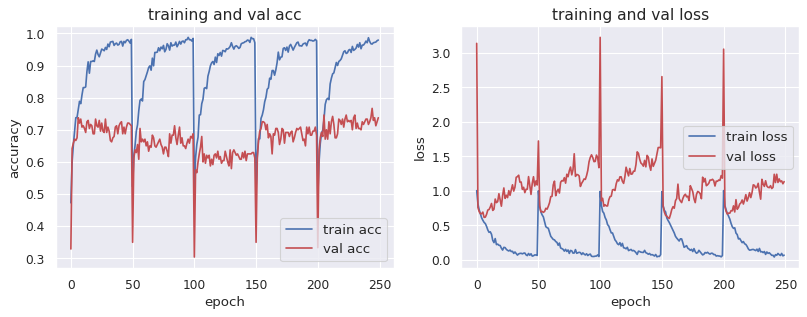

In [58]:
import seaborn as sns
#出力したテンソルのデバイスをCPUへ切り替える
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(CFG.N_EPOCHS*5):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i]
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = CFG.N_EPOCHS

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs*5), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs*5), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs*5), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs*5), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()